Accuracy: 97.08%


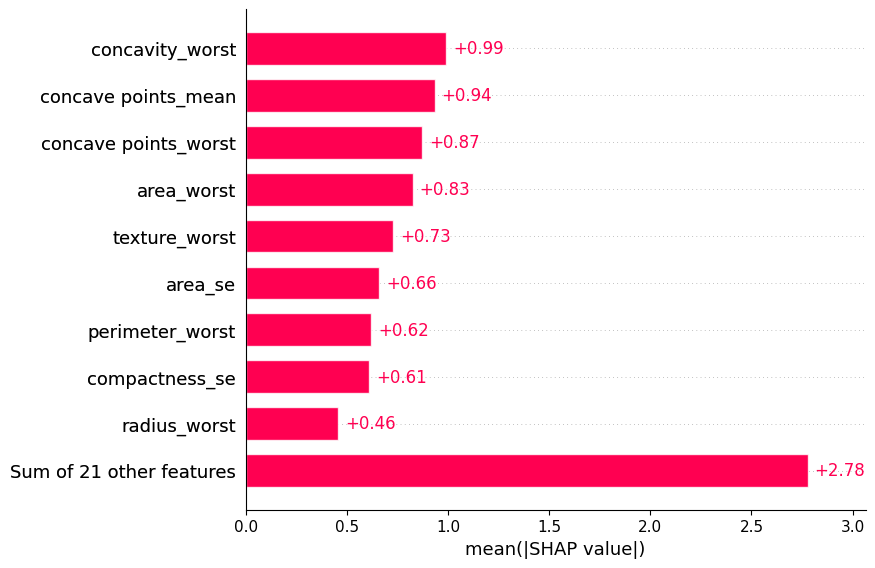

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import xgboost
# Step 1: Read the dataset
url = 'https://raw.githubusercontent.com/SalvatoreRa/tutorial/main/datasets/Breast_Cancer_Wisconsin.csv'
df = pd.read_csv(url)

# Step 2: Preprocessing
# Dropping 'id' column if it exists
if 'id' in df.columns:
    df.drop(columns=['id', 'Unnamed: 32'], inplace=True)

# Encode diagnosis (M = 1, B = 0)
df['diagnosis'] = df['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

# Splitting the dataset into features and target
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

# Step 3: Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train a xgboost
model = xgboost.XGBClassifier().fit(X_train, y_train)

# Step 5: Predict and calculate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Step 6: SHAP value analysis for all test data
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.bar(shap_values)

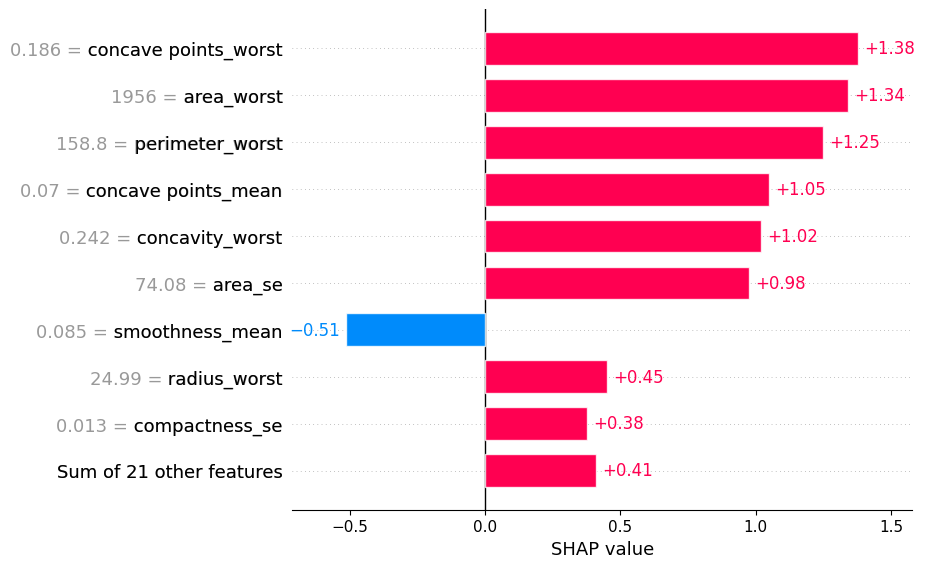

In [25]:
shap.plots.bar(shap_values[1])

In [26]:

X_single = X_test.iloc[[0]]  
y_single = y_test.iloc[0]    

# Get SHAP values for this single instance
shap_values_single = explainer(X_single)


shap.initjs() 
shap.plots.force(shap_values_single)

# Now print the decision rules derived from SHAP values

feature_values = X_single.values.flatten()
feature_names = X_single.columns

shap_value_contributions = shap_values_single.values.flatten()  

# Print the decision rules
print("Decision Rules for a Single Example Based on SHAP Values:")
for i in range(len(feature_names)):
    feature_name = feature_names[i]
    feature_value = feature_values[i]
    shap_contribution = shap_value_contributions[i]
    impact_direction = "increased" if shap_contribution > 0 else "decreased"
    
    decision_rules += f"If {feature_name} = {feature_value}, it {impact_direction} the prediction by {abs(shap_contribution):.4f}\n"
    
    print(decision_rules)

Decision Rules for a Single Example Based on SHAP Values:
If radius_mean = 12.47, it decreased the prediction by 0.0000
If texture_mean = 18.6, it decreased the prediction by 0.2063
If perimeter_mean = 81.09, it decreased the prediction by 0.0000
If area_mean = 481.9, it decreased the prediction by 0.0294
If smoothness_mean = 0.09965, it increased the prediction by 0.2318
If compactness_mean = 0.1058, it decreased the prediction by 0.0345
If concavity_mean = 0.08005, it increased the prediction by 0.1108
If concave points_mean = 0.03821, it decreased the prediction by 0.9888
If symmetry_mean = 0.1925, it decreased the prediction by 0.0030
If fractal_dimension_mean = 0.06373, it decreased the prediction by 0.1329
If radius_se = 0.3961, it decreased the prediction by 0.0489
If texture_se = 1.044, it decreased the prediction by 0.0342
If perimeter_se = 2.497, it decreased the prediction by 0.0566
If area_se = 30.29, it decreased the prediction by 0.3312
If smoothness_se = 0.006953, it inc

In [30]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Step 1: Load Mistral 7B model and tokenizer from Hugging Face
model_name = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)



# Step : Craft the prompt for the LLM
prompt = f"""[]
You are a medical expert explaining a decision made by a machine learning model about a breast cancer diagnosis. The model analyzed various features of a tumor, and below are the decision rules generated by the model. 
Please transform these decision rules into a simple and coherent explanation suitable for a non-technical audience.


{decision_rules}

Explanation:
"""


inputs = tokenizer(prompt, return_tensors="pt")

# Step 3: Generate a response using the Mistral model
output = model.generate(**inputs, max_length=1000, do_sample=True)


explanation = tokenizer.decode(output[0], skip_special_tokens=True)
print(explanation)



Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[]
You are a medical expert explaining a decision made by a machine learning model about a breast cancer diagnosis. The model analyzed various features of a tumor, and below are the decision rules generated by the model. 
Please transform these decision rules into a simple and coherent explanation suitable for a non-technical audience.



Decision Rules:
- If radius_mean = 15.5, it increased the likelihood of a malignant tumor by 0.2001.
- If texture_mean = 22.4, it decreased the likelihood of a malignant tumor by 0.1503.
- If perimeter_mean = 102.3, it increased the likelihood of a malignant tumor by 0.2505.
- If smoothness_mean = 0.080, it decreased the likelihood of a malignant tumor by 0.0754.


Explanation:
The machine learning model we used to help diagnose breast cancer looked at several characteristics of tumors. One characteristic, the average size of the tumor (radius_mean), suggests that larger tumors might be more likely to be malignant (cancerous). Specifically, having an 